# ParTの学習中にエラーが発生するので原因を調査したやつ

- 結論：track数が0のjetが入力されるとエラーが発生する（NaNが出力される）

In [1]:
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
# from torch_geometric.data import Data
# from torch_geometric.loader import DataLoader
from weaver.nn.model import ParticleTransformer
from modules import MyParT

import warnings
# filterwarningsが'ingore'になっているので戻す
warnings.filterwarnings('default')

2023-08-25 17:36:19.939228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Edge特徴量の作成

In [2]:
read_path = "/home/suzukiy/ftag/umami-dataset/umami-018-2/preprocessed/PFlow-hybrid-resampled_scaled_shuffled.h5"
print(os.path.exists(read_path))
# check size in GB
print(f"{os.path.getsize(read_path) / 1024**3:.3f} GB")

True
14.903 GB


In [3]:
pt_idx = 13
deta_idx = 1
dphi_idx = 2

data_size = 100000

write_path = "./dataset/part_test_100k.h5"

scale_dict = {
    "tracks_loose": {
        "pt": {
            "shift": 8.649473797326332,
            "scale": 1.4729186134627081
        }
    }
}

def inverse_scale(x, shift, scale):
    return x * scale + shift

In [4]:
with h5py.File(read_path, "r") as f:
    x = f[f"tracks_loose/inputs"][:data_size][::]
    valid = f[f"tracks_loose/valid"][:data_size][::]
    y = f[f"jets/labels_one_hot"][:data_size][::]

In [5]:
def make_pair_features_v2(
    x:np.ndarray, valid:np.ndarray, pt_idx:int, deta_idx:int, dphi_idx:int
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    make_pair_features
    
    Args:
        x (np.ndarray): (N, F, P)
        valid (np.ndarray): (N, 1, P)
        pt_idx (int): pTのindex
        deta_idx (int): detaのindex
        dphi_idx (int): dphiのindex
        
    Returns:
        uu (np.ndarray): (N, 3, P*P)
        uu_idx (np.ndarray): (N, 2, P*P)
    """
    def subtract_outer(arr):
        return arr[:, :, np.newaxis] - arr[:, np.newaxis, :]
    
    def add_outer(arr):
        return arr[:, :, np.newaxis] + arr[:, np.newaxis, :]
    
    def product_outer(arr):
        return arr[:, :, np.newaxis] * arr[:, np.newaxis, :]
    
    def minimum_outer(arr):
        return np.minimum(arr[:, :, np.newaxis], arr[:, np.newaxis, :])
    
    n, features, points = x.shape
    
    
    pt = x[:, pt_idx, :]
    deta = x[:, deta_idx, :]
    dphi = x[:, dphi_idx, :]
    
    delta = np.sqrt(subtract_outer(deta)**2 + subtract_outer(dphi)**2) # (N, P, P)
    pt_GeV = np.exp(inverse_scale(
        pt,
        scale_dict["tracks_loose"]["pt"]["shift"],
        scale_dict["tracks_loose"]["pt"]["scale"]
    ) /1000) # Norm(log(pT)) [MeV] -> pT[GeV]
    pt_min = minimum_outer(pt_GeV)
    kt = pt_min * delta
    z = pt_min / add_outer(pt_GeV)
    uu = np.log(np.stack([delta, kt, z], axis=-1)) # (N, P, P, 3)
    
    # 対角成分を0にする
    _mask = (1 - np.eye(points).reshape(1, points, points, 1))
    uu = uu * _mask
    uu[np.isnan(uu) == True] = 0. # -np.inf * 0. = nanなので0にする
    
    # (N, P, P, 3) -> (N, P*P, 3)
    uu = uu.reshape(n, points*points, 3)
    
    # validの部分を0にする
    uu_valid = product_outer(valid.squeeze()).reshape(n, points*points)
    uu_valid = np.stack([uu_valid, uu_valid, uu_valid], axis=-1)
    uu = np.where(uu_valid, uu, 0.)
    
    # 排除できなかった-np.infを0にする
    uu = np.where(uu == -np.inf, 0., uu)
    
    # (N, P*P, 3) -> (N, 3, P*P)
    uu = uu.transpose(0, 2, 1)
    
    # indexの取得 (2, P*P)
    uu_idx = np.indices((points, points)).reshape(2, points*points)
    # (2, P*P) -> (N, 2, P*P)
    uu_idx = np.tile(uu_idx, (n, 1, 1))
    
    
    return uu, uu_idx

In [6]:
def make_tensor_pair_features_v2(
    x: torch.Tensor, valid: torch.Tensor, pt_idx: int, deta_idx: int, dphi_idx: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    粒子間相互作用の特徴量のtorch.Tensorを作成する
    
    Args:
        x (torch.Tensor): (N, F, P)
        valid (torch.Tensor): (N, 1, P)
        pt_idx (int): pTのindex
        deta_idx (int): detaのindex
        dphi_idx (int): dphiのindex
        
    Returns:
        uu (torch.Tensor): (N, 3, P*P)
        uu_idx (torch.Tensor): (N, 2, P*P)
    """
    def subtract_outer(arr):
        return arr[:, :, None] - arr[:, None, :]
    
    def add_outer(arr):
        return arr[:, :, None] + arr[:, None, :]
    
    def product_outer(arr):
        return arr[:, :, None] * arr[:, None, :]
    
    def minimum_outer(arr):
        return torch.min(arr[:, :, None], arr[:, None, :])
    
    n, features, points = x.shape
    
    
    pt = x[:, pt_idx, :]
    deta = x[:, deta_idx, :]
    dphi = x[:, dphi_idx, :]
    
    delta = torch.sqrt(subtract_outer(deta)**2 + subtract_outer(dphi)**2) # (N, P, P)
    pt_GeV = torch.exp(inverse_scale(
        pt,
        scale_dict["tracks_loose"]["pt"]["shift"],
        scale_dict["tracks_loose"]["pt"]["scale"]
    ) /1000) # Norm(log(pT)) [MeV] -> pT[GeV]
    pt_min = minimum_outer(pt_GeV)
    kt = pt_min * delta
    z = pt_min / add_outer(pt_GeV)
    uu = torch.log(torch.stack([delta, kt, z], dim=-1)) # (N, P, P, 3)
    
    # 対角成分を0にする
    _mask = (1 - torch.eye(points).view(1, points, points, 1))
    uu = uu * _mask
    uu[torch.isnan(uu)] = 0. # -inf * 0. = nanなので0にする
    
    # (N, P, P, 3) -> (N, P*P, 3)
    uu = uu.view(n, points*points, 3)
    
    # validの部分を0にする
    uu_valid = product_outer(valid.squeeze()).view(n, points*points)
    uu_valid = torch.stack([uu_valid, uu_valid, uu_valid], dim=-1)
    uu = torch.where(uu_valid.to(torch.bool), uu, torch.zeros_like(uu))
    
    # 排除できなかった-infを0にする
    uu = torch.where(uu == float('-inf'), torch.zeros_like(uu), uu)
    
    # (N, P*P, 3) -> (N, 3, P*P)
    uu = uu.permute(0, 2, 1)
    
    # indexの取得 (2, P*P)
    uu_idx = torch.stack(torch.meshgrid(torch.arange(points), torch.arange(points))).reshape(2, points*points)
    # (2, P*P) -> (N, 2, P*P)
    uu_idx = uu_idx.expand(n, -1, -1)
    
    
    return uu, uu_idx


In [7]:
x = x.transpose(0, 2, 1) # (N, P, F) -> (N, F, P)
valid = valid[:, np.newaxis, :] # (N, P) -> (N, 1, P)

In [8]:
uu, uu_idx = make_pair_features_v2(x, valid, pt_idx, deta_idx, dphi_idx)
print(uu.shape, uu_idx.shape)

divide by zero encountered in log
invalid value encountered in multiply


(100000, 3, 1600) (100000, 2, 1600)


In [11]:
dataset = TensorDataset(
    torch.from_numpy(x).float(),
    torch.from_numpy(valid).float(),
    torch.from_numpy(uu).float(),
    torch.from_numpy(uu_idx).float(),
    torch.from_numpy(y).float()
)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=False)

In [13]:
for _x, _valid, _uu, _uu_idx, _y in dataloader:
    print(_uu)
    _uu2, _uu_idx2 = make_tensor_pair_features_v2(_x, _valid, pt_idx, deta_idx, dphi_idx)
    print(_uu)
    break

tensor([[[ 0.0000, -3.9805, -4.1866,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -3.9735, -4.1798,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.6941, -0.6942,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -3.1110, -3.0327,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -3.1017, -3.0230,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.6933, -0.6943,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -1.6350, -2.7203,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.6272, -2.7125,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.6936, -0.6936,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000, -3.3602, -2.4365,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -3.3512, -2.4272,  ...,  0.0000,  0.0000,  0.0000],
         [-0.0000, -0.6934, -0.6932,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000, -1.9233, -2.0308,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000, -1.9169, -2.0227,  ...,  0.0000,  0.

In [11]:
for _x, _valid, _uu, _uu_idx, _y in dataloader:
    print(_x.shape, _valid.shape, _uu.shape, _uu_idx.shape, _y.shape)
    print(torch.any(torch.isnan(_x)), torch.any(torch.isnan(_valid)), torch.any(torch.isnan(_uu)), torch.any(torch.isnan(_uu_idx)), torch.any(torch.isnan(_y)))
    break

torch.Size([1000, 20, 40]) torch.Size([1000, 1, 40]) torch.Size([1000, 3, 1600]) torch.Size([1000, 2, 1600]) torch.Size([1000, 3])
tensor(False) tensor(False) tensor(False) tensor(False) tensor(False)


In [12]:
parT_tagger_kwargs = {
    'pf_input_dim': 20,
    'num_classes': 3,
    'pair_input_dim': 0,
    'pair_extra_dim': 3,
    'remove_self_pair': True,
    'use_pre_activation_pair': True,
    'embed_dims': [128, 512, 128],
    'pair_embed_dims': [64, 64, 64],
    'num_heads': 8,
    'num_layers': 8,
    'num_cls_layers': 2,
    'block_params': None,
    'cls_block_params': {'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
    'fc_params': [],
    'activation': 'gelu',
    'trim': True,
    'for_inference': False,
    'use_amp': False
}

In [29]:
import importlib
importlib.reload(MyParT)

<module 'modules.MyParT' from '/home/suzukiy/ftag/particlenet-ftag/modules/MyParT.py'>

In [30]:
model = MyParT.MyParTTagger(**parT_tagger_kwargs)

In [31]:
summary(
    model,
    [[1000, 20, 40], [1000, 1, 40], [1000, 3, 1600], [1000, 2, 1600]],
)

Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.


Layer (type:depth-idx)                             Output Shape              Param #
MyParTTagger                                       [1000, 3]                 --
├─SequenceTrimmer: 1-1                             [1000, 20, 40]            --
├─Embed: 1-2                                       [40, 1000, 128]           --
│    └─BatchNorm1d: 2-1                            [1000, 20, 40]            40
│    └─Sequential: 2-2                             [40, 1000, 128]           --
│    │    └─LayerNorm: 3-1                         [40, 1000, 20]            40
│    │    └─Linear: 3-2                            [40, 1000, 128]           2,688
│    │    └─GELU: 3-3                              [40, 1000, 128]           --
│    │    └─LayerNorm: 3-4                         [40, 1000, 128]           256
│    │    └─Linear: 3-5                            [40, 1000, 512]           66,048
│    │    └─GELU: 3-6                              [40, 1000, 512]           --
│    │    └─LayerNorm: 3-7 

In [18]:
with torch.autograd.detect_anomaly():
    for _x, _valid, _uu, _uu_idx, _y in dataloader:
        out = model(
            pf_x = _x,
            pf_v = None,
            pf_mask = _valid,
            pf_uu = _uu,
            pf_uu_idx = _uu_idx,
        )
        break

Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.


In [19]:
out.shape

torch.Size([1000, 3])

In [20]:
out

tensor([[ 0.5147,  1.0992,  0.4815],
        [ 0.6673,  0.7578,  0.2466],
        [-0.0046,  0.3517,  0.4121],
        ...,
        [-0.2578,  1.3192,  0.9723],
        [-0.1155,  0.3044,  0.2269],
        [-0.9146,  0.1925,  0.6895]], grad_fn=<AddmmBackward0>)

## maskされているかどうかを確認する

In [1]:
import os
from typing import Tuple, Dict, List, Union, Any, Optional
import argparse
import random
import warnings

import h5py
import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from weaver.nn.model import ParticleNet

from modules import data, eval, exec, fix_seed, MyParT, file_util

2023-08-18 14:05:49.080650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dir_path = "./models/parT/GN1-100k"
with open(os.path.join(dir_path, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [3]:
dir_path = config["dataset"]["data_path"]
batch_size = config["hyperparameters"]["batch_size"]
var_trks_use = config["dataset"]["var_trks_use"]
var_trks_all = config["dataset"]["var_trks_all"]

size = 1000000

dtype = torch.float32 # torch.float16 is not supported by torch.sqrt(), etc.

In [4]:
dataloader = data.InMemoryDataLoader(
    is_validation=False,
    dir_path= dir_path,
    batch_size= batch_size,
    var_trks_use= var_trks_use,
    var_trks_all= var_trks_all,
    size = size,
    dtype= dtype,
).dataloader()

In [5]:
def inverse_scale(x, shift, scale):
    return x * scale + shift

def make_tensor_pair_features(
    x: torch.Tensor, valid: torch.Tensor, lorentz_idx: dict, scale_dict: dict
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    粒子間相互作用の特徴量のtorch.Tensorを作成する
    
    Args:
        x (torch.Tensor): (N, F, P)
        valid (torch.Tensor): (N, 1, P)
        pt_idx (int): pTのindex
        deta_idx (int): detaのindex
        dphi_idx (int): dphiのindex
        
    Returns:
        uu (torch.Tensor): (N, 3, P*P)
        uu_idx (torch.Tensor): (N, 2, P*P)
    """
    def subtract_outer(arr):
        return arr[:, :, None] - arr[:, None, :]
    
    def add_outer(arr):
        return arr[:, :, None] + arr[:, None, :]
    
    def product_outer(arr):
        return arr[:, :, None] * arr[:, None, :]
    
    def minimum_outer(arr):
        return torch.min(arr[:, :, None], arr[:, None, :])
    
    n, features, points = x.shape
    
    
    pt = x[:, lorentz_idx["pt"], :]
    deta = x[:, lorentz_idx["deta"], :]
    dphi = x[:, lorentz_idx["dphi"], :]
    
    delta = torch.sqrt(subtract_outer(deta)**2 + subtract_outer(dphi)**2) # (N, P, P)
    pt_GeV = torch.exp(inverse_scale(
        pt,
        scale_dict["tracks_loose"]["pt"]["shift"],
        scale_dict["tracks_loose"]["pt"]["scale"]
    ) /1000) # Norm(log(pT)) [MeV] -> pT[GeV]
    pt_min = minimum_outer(pt_GeV)
    kt = pt_min * delta
    z = pt_min / add_outer(pt_GeV)
    # uu = torch.log1p(torch.stack([delta, kt, z], dim=-1)) # (N, P, P, 3)
    uu = torch.stack([delta, kt, z], dim=-1) # (N, P, P, 3)
    
    # 対角成分を0にする
    _mask = (1 - torch.eye(points).view(1, points, points, 1))
    uu = uu * _mask
    uu[torch.isnan(uu)] = 0. # -inf * 0. = nanなので0にする
    
    # (N, P, P, 3) -> (N, P*P, 3)
    uu = uu.view(n, points*points, 3)
    
    # validの部分を0にする
    uu_valid = product_outer(valid.squeeze()).view(n, points*points)
    uu_valid = torch.stack([uu_valid, uu_valid, uu_valid], dim=-1)
    uu = torch.where(uu_valid.to(torch.bool), uu, torch.zeros_like(uu))
    
    # 排除できなかった-infを0にする
    uu = torch.where(uu == float('-inf'), torch.zeros_like(uu), uu)
    
    # (N, P*P, 3) -> (N, 3, P*P)
    uu = uu.permute(0, 2, 1)
    
    # indexの取得 (2, P*P)
    uu_idx = torch.stack(torch.meshgrid(torch.arange(points), torch.arange(points))).reshape(2, points*points)
    # (2, P*P) -> (N, 2, P*P)
    uu_idx = uu_idx.expand(n, -1, -1)
    
    
    return uu, uu_idx

def make_tensor_pair_features_nolog(
    x: torch.Tensor, valid: torch.Tensor, lorentz_idx: dict
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    粒子間相互作用の特徴量のtorch.Tensorを作成する
    
    Args:
        x (torch.Tensor): (N, F, P)
        valid (torch.Tensor): (N, 1, P)
        pt_idx (int): pTのindex
        deta_idx (int): detaのindex
        dphi_idx (int): dphiのindex
        
    Returns:
        uu (torch.Tensor): (N, 3, P*P)
        uu_idx (torch.Tensor): (N, 2, P*P)
    """
    def subtract_outer(arr):
        return arr[:, :, None] - arr[:, None, :]
    
    def add_outer(arr):
        return arr[:, :, None] + arr[:, None, :]
    
    def product_outer(arr):
        return arr[:, :, None] * arr[:, None, :]
    
    def minimum_outer(arr):
        return torch.min(arr[:, :, None], arr[:, None, :])
    
    n, features, points = x.shape
    
    
    pt = x[:, lorentz_idx["pt"], :]
    deta = x[:, lorentz_idx["deta"], :]
    dphi = x[:, lorentz_idx["dphi"], :]
    
    delta = torch.sqrt(subtract_outer(deta)**2 + subtract_outer(dphi)**2) # (N, P, P)
    pt_min = minimum_outer(pt)
    kt = pt_min * delta
    z = pt_min / add_outer(pt)
    # uu = torch.log1p(torch.stack([delta, kt, z], dim=-1)) # (N, P, P, 3)
    uu = torch.stack([delta, kt, z], dim=-1) # (N, P, P, 3)
    
    # 対角成分を0にする
    _mask = (1 - torch.eye(points).view(1, points, points, 1))
    uu = uu * _mask
    uu[torch.isnan(uu)] = 0. # -inf * 0. = nanなので0にする
    
    # (N, P, P, 3) -> (N, P*P, 3)
    uu = uu.view(n, points*points, 3)
    
    # validの部分を0にする
    uu_valid = product_outer(valid.squeeze()).view(n, points*points)
    uu_valid = torch.stack([uu_valid, uu_valid, uu_valid], dim=-1)
    uu = torch.where(uu_valid.to(torch.bool), uu, torch.zeros_like(uu))
    
    # 排除できなかった-infを0にする
    uu = torch.where(uu == float('-inf'), torch.zeros_like(uu), uu)
    
    # (N, P*P, 3) -> (N, 3, P*P)
    uu = uu.permute(0, 2, 1)
    
    # 全結合グラフのindexの取得 (2, P*P)
    uu_idx = torch.stack(torch.meshgrid(torch.arange(points), torch.arange(points), indexing="xy")).reshape(2, points*points)
    uu_idx = uu_idx.expand(n, -1, -1)
    
    return uu, uu_idx

In [6]:
def get_lorentz_idx(var_trks_use:List[str]):
    return {
        "pt": var_trks_use.index("pt"),
        "deta": var_trks_use.index("deta"),
        "dphi": var_trks_use.index("dphi"),
    }

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = MyParT.MyParTTagger(**config["hyperparameters"]["model"])
if torch.cuda.is_available():
    model.cuda()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["hyperparameters"]["optimizer"]["lr_init"],
    weight_decay=config["hyperparameters"]["optimizer"]["weight_decay"],
)
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

In [9]:
for i, (X, y) in enumerate(dataloader):
    print(i, X.shape, y.shape)
    if i == 0:
        break

0 torch.Size([1000, 22, 40]) torch.Size([1000, 3])


In [10]:
torch.autograd.set_detect_anomaly(True)
model.train()
for i, (X, y) in enumerate(dataloader):
    print(i)
    # print(ii, X.shape, y.shape)
    mask = (X[:, 0, :][:,None,:]!=0) # (N, 1, P)
    uu, uu_idx = make_tensor_pair_features_nolog(X, mask, get_lorentz_idx(var_trks_use))

    print(X.shape, mask.shape, uu.shape, uu_idx.shape, y.shape)
    
    if uu.max() == torch.inf or uu.min() == -torch.inf:
        raise ValueError("Inf detected in input Tensor!")
    
    if torch.any(torch.isnan(uu)) or torch.any(torch.isnan(uu_idx)) or torch.any(torch.isnan(X)) or torch.any(torch.isnan(y)) or torch.any(torch.isnan(mask)):
        raise ValueError("NaN detected in input Tensor!")
    
    features = X.to(device)
    mask = mask.to(device)
    uu = uu.to(device) # (N, F, P*P)
    uu_idx = uu_idx.to(device) # (N, 2, P*P)
    y = y.to(device)
    
    optimizer.zero_grad()
    y_pred = model(features, mask, uu, uu_idx)

    # print(y_pred)
    
    if torch.any(torch.isnan(y_pred.detach().cpu())):
        print(torch.isnan(y_pred.detach().cpu()).sum())
        y = y[~torch.isnan(y_pred.detach().cpu())]
        y_pred = y_pred[~torch.isnan(y_pred.detach().cpu())]
    
    print(torch.any(torch.isnan(y_pred.detach().cpu())))
        
    
    loss = loss_fn(y_pred, y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()

0
torch.Size([1000, 22, 40]) torch.Size([1000, 1, 40]) torch.Size([1000, 3, 1600]) torch.Size([1000, 2, 1600]) torch.Size([1000, 3])
torch.Size([40, 1000, 128])
torch.Size([1000, 3, 40, 40])
tensor(False)
1
torch.Size([1000, 22, 40]) torch.Size([1000, 1, 40]) torch.Size([1000, 3, 1600]) torch.Size([1000, 2, 1600]) torch.Size([1000, 3])
torch.Size([40, 1000, 128])
torch.Size([1000, 3, 40, 40])
tensor(3)
tensor(False)


RuntimeError: Function 'AddmmBackward0' returned nan values in its 2th output.

## Indexの確認

In [17]:
import torch
import numpy as np

In [18]:
a = torch.Tensor([[1,2,3],[4,5,6], [7,8,9], [10,11,12]])

In [19]:
def tensor_add_outer(a, b):
    return a[:, None] + b[None, :]

def tensor_product_outer(a, b):
    return a[:, None] * b[None, :]

aa = tensor_product_outer(a, a)

In [20]:
print(a.shape, aa.shape)

torch.Size([4, 3]) torch.Size([4, 4, 3])


In [28]:
torch.stack(torch.meshgrid(torch.arange(3), torch.arange(3), indexing='ij')).reshape(2, -1)

tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2],
        [0, 1, 2, 0, 1, 2, 0, 1, 2]])

In [21]:
print(a)
print(aa)

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.],
        [ 7.,  8.,  9.],
        [10., 11., 12.]])
tensor([[[  1.,   4.,   9.],
         [  4.,  10.,  18.],
         [  7.,  16.,  27.],
         [ 10.,  22.,  36.]],

        [[  4.,  10.,  18.],
         [ 16.,  25.,  36.],
         [ 28.,  40.,  54.],
         [ 40.,  55.,  72.]],

        [[  7.,  16.,  27.],
         [ 28.,  40.,  54.],
         [ 49.,  64.,  81.],
         [ 70.,  88., 108.]],

        [[ 10.,  22.,  36.],
         [ 40.,  55.,  72.],
         [ 70.,  88., 108.],
         [100., 121., 144.]]])


## dummyでもダメだったのでi/o tensorを確認する

In [15]:
import h5py

h5_file = "./nan_debug_20230825_173207.h5"

with h5py.File(h5_file, "r") as f:
    X = f["X"][:]
    y = f["y"][:]
    mask = f["mask"][:]
    vec = f["vec"][:]
    y_pred = f["y_pred"][:]

print(X.shape, y.shape, mask.shape, vec.shape, y_pred.shape)

dict_tensors = {"X": X, "y": y, "mask": mask, "vec": vec, "y_pred": y_pred}

(1000, 21, 40) (1000, 3) (1000, 1, 40) (1000, 4, 40) (1000, 3)


In [17]:
for k, v in dict_tensors.items():
    if np.any(np.isnan(v)):
        print(k, np.any(np.isnan(v)))

y_pred True


In [13]:
if np.any(np.isnan(y_pred)):
    # get nan index
    nan_idx = np.arange(len(y_pred))[np.isnan(y_pred).sum(1) > 0]
    print(nan_idx)

[24]


In [21]:
train_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled.h5"

from modules import file_util

file_util.display_h5_file(train_path)

Displaying contents of file: /home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled.h5
/jets: [Group]
  /jets/add_labels: [Group]
    /jets/add_labels/mass: [Dataset](22919706,)
    /jets/add_labels/pt: [Dataset](22919706,)
  /jets/inputs: [Dataset](22919706, 2)
  /jets/labels: [Dataset](22919706,)
  /jets/labels_one_hot: [Dataset](22919706, 3)
  /jets/weight: [Dataset](22919706,)
/tracks_loose: [Group]
  /tracks_loose/inputs: [Dataset](22919706, 40, 21)
  /tracks_loose/labels: [Group]
    /tracks_loose/labels/truthOriginLabel: [Dataset](22919706, 40)
    /tracks_loose/labels/truthVertexIndex: [Dataset](22919706, 40)
  /tracks_loose/valid: [Dataset](22919706, 40)


In [26]:
# read /tracks_loose/vaild
with h5py.File(train_path, "r") as f:
    valid = f["tracks_loose/valid"][::].sum(1)

In [29]:
valid.min(), valid.max()

(0, 40)

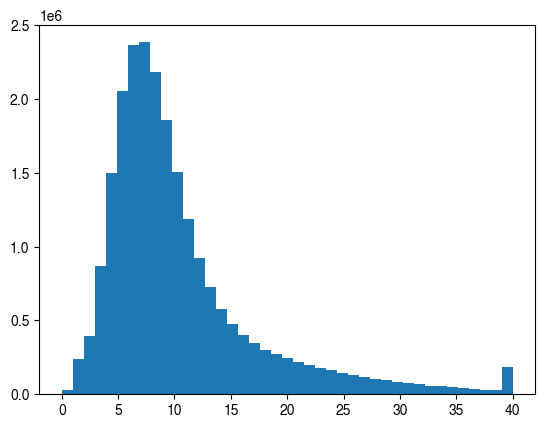

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(valid, bins=41, range=(0, 40))
plt.show()

In [36]:
import h5py
import numpy as np
from tqdm import tqdm

input_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled.h5"
output_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5"

chunk_size = 100000  # この値をメモリに合わせて調整してください

# 取り除くべきインデックスを取得
with h5py.File(input_path, 'r') as original_file:
    valid_dataset = original_file['/tracks_loose/valid']
    indices_to_remove = np.where(valid_dataset[:].sum(axis=1) == 0)[0]

# 新しいh5ファイルにフィルタリングされたデータを書き込む
with h5py.File(input_path, 'r') as original_file, h5py.File(output_path, 'w') as new_file:
    for path in [
        '/jets/add_labels/mass',
        '/jets/add_labels/pt',
        '/jets/inputs',
        '/jets/labels',
        '/jets/labels_one_hot',
        '/jets/weight',
        '/tracks_loose/inputs',
        '/tracks_loose/labels/truthOriginLabel',
        '/tracks_loose/labels/truthVertexIndex',
        '/tracks_loose/valid'
    ]:
        print(path)
        original_dataset = original_file[path]
        shape = original_dataset.shape
        new_shape = (shape[0] - len(indices_to_remove), *shape[1:])
        new_dataset = new_file.create_dataset(path, shape=new_shape)

        new_index = 0
        for i in tqdm(range(0, shape[0], chunk_size)):
            chunk = original_dataset[i:i + chunk_size]
            filtered_chunk = np.delete(chunk, indices_to_remove[(indices_to_remove >= i) & (indices_to_remove < i + chunk_size)] - i, axis=0)
            new_dataset[new_index:new_index + len(filtered_chunk)] = filtered_chunk
            new_index += len(filtered_chunk)

/jets/add_labels/mass


100%|██████████| 230/230 [00:00<00:00, 315.17it/s]


/jets/add_labels/pt


100%|██████████| 230/230 [00:00<00:00, 314.26it/s]


/jets/inputs


100%|██████████| 230/230 [00:03<00:00, 71.64it/s]


/jets/labels


100%|██████████| 230/230 [00:00<00:00, 680.70it/s]


/jets/labels_one_hot


100%|██████████| 230/230 [00:00<00:00, 251.81it/s]


/jets/weight


100%|██████████| 230/230 [00:01<00:00, 168.93it/s]


/tracks_loose/inputs


100%|██████████| 230/230 [16:43<00:00,  4.36s/it]


/tracks_loose/labels/truthOriginLabel


100%|██████████| 230/230 [01:38<00:00,  2.33it/s]


/tracks_loose/labels/truthVertexIndex


100%|██████████| 230/230 [01:38<00:00,  2.34it/s]


/tracks_loose/valid


100%|██████████| 230/230 [00:13<00:00, 16.70it/s]


In [37]:
train_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5"

from modules import file_util

file_util.display_h5_file(train_path)

Displaying contents of file: /home/suzukiy/ftag/umami-dataset/umami-020-GNx/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5
/jets: [Group]
  /jets/add_labels: [Group]
    /jets/add_labels/mass: [Dataset](22888197,)
    /jets/add_labels/pt: [Dataset](22888197,)
  /jets/inputs: [Dataset](22888197, 2)
  /jets/labels: [Dataset](22888197,)
  /jets/labels_one_hot: [Dataset](22888197, 3)
  /jets/weight: [Dataset](22888197,)
/tracks_loose: [Group]
  /tracks_loose/inputs: [Dataset](22888197, 40, 21)
  /tracks_loose/labels: [Group]
    /tracks_loose/labels/truthOriginLabel: [Dataset](22888197, 40)
    /tracks_loose/labels/truthVertexIndex: [Dataset](22888197, 40)
  /tracks_loose/valid: [Dataset](22888197, 40)


In [1]:
import h5py
import numpy as np
from tqdm import tqdm

input_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-resampled_scaled_shuffled.h5"
output_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5"

chunk_size = 100000  # この値をメモリに合わせて調整してください

# 取り除くべきインデックスを取得
with h5py.File(input_path, 'r') as original_file:
    valid_dataset = original_file['/tracks_loose/valid']
    indices_to_remove = np.where(valid_dataset[:].sum(axis=1) == 0)[0]

# 新しいh5ファイルにフィルタリングされたデータを書き込む
with h5py.File(input_path, 'r') as original_file, h5py.File(output_path, 'w') as new_file:
    for path in [
        '/jets/add_labels/mass',
        '/jets/add_labels/pt',
        '/jets/inputs',
        '/jets/labels',
        '/jets/labels_one_hot',
        '/jets/weight',
        '/tracks_loose/inputs',
        '/tracks_loose/labels/truthOriginLabel',
        '/tracks_loose/labels/truthVertexIndex',
        '/tracks_loose/valid'
    ]:
        print(path)
        original_dataset = original_file[path]
        shape = original_dataset.shape
        new_shape = (shape[0] - len(indices_to_remove), *shape[1:])
        new_dataset = new_file.create_dataset(path, shape=new_shape)

        new_index = 0
        for i in tqdm(range(0, shape[0], chunk_size)):
            chunk = original_dataset[i:i + chunk_size]
            filtered_chunk = np.delete(chunk, indices_to_remove[(indices_to_remove >= i) & (indices_to_remove < i + chunk_size)] - i, axis=0)
            new_dataset[new_index:new_index + len(filtered_chunk)] = filtered_chunk
            new_index += len(filtered_chunk)

/jets/add_labels/mass


100%|██████████| 230/230 [00:00<00:00, 305.44it/s]


/jets/add_labels/pt


100%|██████████| 230/230 [00:00<00:00, 275.13it/s]


/jets/inputs


100%|██████████| 230/230 [00:03<00:00, 65.26it/s]


/jets/labels


100%|██████████| 230/230 [00:00<00:00, 589.98it/s]


/jets/labels_one_hot


100%|██████████| 230/230 [00:01<00:00, 195.78it/s]


/jets/weight


100%|██████████| 230/230 [00:01<00:00, 135.32it/s]


/tracks_loose/inputs


100%|██████████| 230/230 [17:38<00:00,  4.60s/it]


/tracks_loose/labels/truthOriginLabel


100%|██████████| 230/230 [01:38<00:00,  2.33it/s]


/tracks_loose/labels/truthVertexIndex


100%|██████████| 230/230 [01:37<00:00,  2.35it/s]


/tracks_loose/valid


100%|██████████| 230/230 [00:12<00:00, 18.44it/s]


In [3]:
train_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5"

from modules import file_util

file_util.display_h5_file(train_path)

Displaying contents of file: /home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-resampled_scaled_shuffled_2.h5
/jets: [Group]
  /jets/add_labels: [Group]
    /jets/add_labels/mass: [Dataset](22888197,)
    /jets/add_labels/pt: [Dataset](22888197,)
  /jets/inputs: [Dataset](22888197, 2)
  /jets/labels: [Dataset](22888197,)
  /jets/labels_one_hot: [Dataset](22888197, 3)
  /jets/weight: [Dataset](22888197,)
/tracks_loose: [Group]
  /tracks_loose/inputs: [Dataset](22888197, 40, 22)
  /tracks_loose/labels: [Group]
    /tracks_loose/labels/truthOriginLabel: [Dataset](22888197, 40)
    /tracks_loose/labels/truthVertexIndex: [Dataset](22888197, 40)
  /tracks_loose/valid: [Dataset](22888197, 40)


In [1]:
input_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5"

from modules import file_util
file_util.display_h5_file(input_path)

2023-08-27 16:39:48.621382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Displaying contents of file: /home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5
/jets: [Group]
  /jets/add_labels: [Group]
    /jets/add_labels/mass: [Dataset](3999999,)
    /jets/add_labels/pt: [Dataset](3999999,)
  /jets/inputs: [Dataset](3999999, 2)
  /jets/labels: [Dataset](3999999,)
  /jets/labels_one_hot: [Dataset](3999999, 3)
  /jets/weight: [Dataset](3999999,)
/tracks_loose: [Group]
  /tracks_loose/inputs: [Dataset](3999999, 40, 22)
  /tracks_loose/labels: [Group]
    /tracks_loose/labels/truthOriginLabel: [Dataset](3999999, 40)
    /tracks_loose/labels/truthVertexIndex: [Dataset](3999999, 40)
  /tracks_loose/valid: [Dataset](3999999, 40)


In [2]:
import h5py
import numpy as np
from tqdm import tqdm

input_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5"
output_path = "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled_2.h5"

chunk_size = 100000  # この値をメモリに合わせて調整してください

# 取り除くべきインデックスを取得
with h5py.File(input_path, 'r') as original_file:
    valid_dataset = original_file['/tracks_loose/valid']
    indices_to_remove = np.where(valid_dataset[:].sum(axis=1) == 0)[0]

# 新しいh5ファイルにフィルタリングされたデータを書き込む
with h5py.File(input_path, 'r') as original_file, h5py.File(output_path, 'w') as new_file:
    for path in [
        '/jets/add_labels/mass',
        '/jets/add_labels/pt',
        '/jets/inputs',
        '/jets/labels',
        '/jets/labels_one_hot',
        '/jets/weight',
        '/tracks_loose/inputs',
        '/tracks_loose/labels/truthOriginLabel',
        '/tracks_loose/labels/truthVertexIndex',
        '/tracks_loose/valid'
    ]:
        print(path)
        original_dataset = original_file[path]
        shape = original_dataset.shape
        new_shape = (shape[0] - len(indices_to_remove), *shape[1:])
        new_dataset = new_file.create_dataset(path, shape=new_shape)

        new_index = 0
        for i in tqdm(range(0, shape[0], chunk_size)):
            chunk = original_dataset[i:i + chunk_size]
            filtered_chunk = np.delete(chunk, indices_to_remove[(indices_to_remove >= i) & (indices_to_remove < i + chunk_size)] - i, axis=0)
            new_dataset[new_index:new_index + len(filtered_chunk)] = filtered_chunk
            new_index += len(filtered_chunk)

/jets/add_labels/mass


100%|██████████| 40/40 [00:00<00:00, 180.99it/s]


/jets/add_labels/pt


100%|██████████| 40/40 [00:00<00:00, 272.36it/s]


/jets/inputs


100%|██████████| 40/40 [00:00<00:00, 67.49it/s]


/jets/labels


100%|██████████| 40/40 [00:00<00:00, 494.88it/s]


/jets/labels_one_hot


100%|██████████| 40/40 [00:00<00:00, 206.24it/s]


/jets/weight


100%|██████████| 40/40 [00:00<00:00, 171.10it/s]


/tracks_loose/inputs


100%|██████████| 40/40 [03:03<00:00,  4.59s/it]


/tracks_loose/labels/truthOriginLabel


100%|██████████| 40/40 [00:17<00:00,  2.26it/s]


/tracks_loose/labels/truthVertexIndex


100%|██████████| 40/40 [00:18<00:00,  2.19it/s]


/tracks_loose/valid


100%|██████████| 40/40 [00:02<00:00, 16.78it/s]


In [3]:
import os
# change filename
os.rename(
    "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5",
    "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled_default.h5"
)
os.rename(
    "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled_2.h5",
    "/home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5"
)

In [4]:
from modules import file_util
file_util.display_h5_file(input_path)

Displaying contents of file: /home/suzukiy/ftag/umami-dataset/umami-020-GNx-pt/preprocessed/PFlow-hybrid-validation-resampled_scaled_shuffled.h5
/jets: [Group]
  /jets/add_labels: [Group]
    /jets/add_labels/mass: [Dataset](3994992,)
    /jets/add_labels/pt: [Dataset](3994992,)
  /jets/inputs: [Dataset](3994992, 2)
  /jets/labels: [Dataset](3994992,)
  /jets/labels_one_hot: [Dataset](3994992, 3)
  /jets/weight: [Dataset](3994992,)
/tracks_loose: [Group]
  /tracks_loose/inputs: [Dataset](3994992, 40, 22)
  /tracks_loose/labels: [Group]
    /tracks_loose/labels/truthOriginLabel: [Dataset](3994992, 40)
    /tracks_loose/labels/truthVertexIndex: [Dataset](3994992, 40)
  /tracks_loose/valid: [Dataset](3994992, 40)
